In [4]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [5]:
!pwd

/content/eva5/w7


In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

from model.train import train
from model.cnn import Net
from model.eval import val
from model.utils import cuda_init, cross_entropy_loss, sgd_optimizer, model_summary

from dataset.dataset import cifar10_dataset, cifar10_classes
from dataset.download import download_cifar10

import numpy as np

from tqdm import tqdm


### Init Device

In [7]:
RAND_VAL = 42

TRAIN_BATCH_SIZE = 512
TEST_BATCH_SIZE = TRAIN_BATCH_SIZE
NUM_WORKER = 64

In [8]:
cuda, dev = cuda_init(RAND_VAL)
print(cuda, dev)

True cuda


In [9]:
!nvidia-smi

Sun Sep 13 21:00:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    34W /  70W |   4639MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Fetch and Check the data

In [10]:
DS = download_cifar10()
Classes = cifar10_classes()

data = DS.data
labels = DS.targets

Files already downloaded and verified


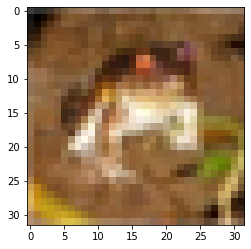

fig:  frog 




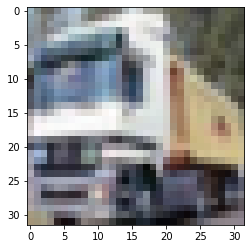

fig:  truck 




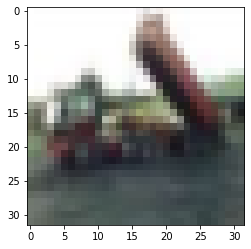

fig:  truck 




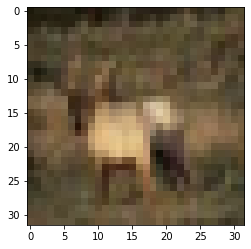

fig:  deer 




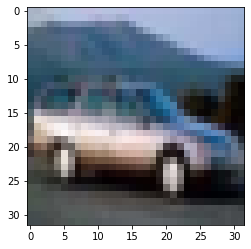

fig:  car 




In [11]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.imshow(data[i])
    plt.show()
    print('fig: ',Classes[labels[i]], '\n\n')

### Data Loaders

In [12]:
train_loader = cifar10_dataset(TRAIN_BATCH_SIZE, cuda, NUM_WORKER, train=True)
test_loader = cifar10_dataset(TEST_BATCH_SIZE, cuda, NUM_WORKER, train = False)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
DROPOUT = 0.1
model = Net(DROPOUT).to(dev)

In [14]:
image_size = np.transpose(data[1],(2,0,1)).shape
model_summary(model, image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,496
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           2,080
           Conv2d-11           [-1, 32, 16, 16]           9,248
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1, 32,

In [15]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

EPOCHS = 40
LEARNING_RATE = 0.01
MOMENTUM = 0.9


losses = []
accuracies = []
incorrect_samples = []

criterion = cross_entropy_loss()  # Create loss function
optimizer = sgd_optimizer(model, LEARNING_RATE, MOMENTUM)  # Create optimizer

# optimizer = optim.SGD(model.parameters(), lr=0.5, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

for epoch in range(1, EPOCHS + 1):
    print(f'Epoch {epoch}:')
    train(model, train_loader, dev, optimizer, criterion)
    # scheduler.step()
    val(model, test_loader, dev, criterion, losses, accuracies, incorrect_samples)

  0%|          | 0/98 [00:00<?, ?it/s]
Validation set: Average loss: 0.0028, Accuracy: 4794/10000 (47.94%)

Epoch 2:
  0%|          | 0/98 [00:00<?, ?it/s]
Validation set: Average loss: 0.0022, Accuracy: 6102/10000 (61.02%)

Epoch 3:
  0%|          | 0/98 [00:00<?, ?it/s]
Validation set: Average loss: 0.0020, Accuracy: 6515/10000 (65.15%)

Epoch 4:
  0%|          | 0/98 [00:00<?, ?it/s]
Validation set: Average loss: 0.0018, Accuracy: 6709/10000 (67.09%)

Epoch 5:
  0%|          | 0/98 [00:00<?, ?it/s]
Validation set: Average loss: 0.0017, Accuracy: 6885/10000 (68.85%)

Epoch 6:
  0%|          | 0/98 [00:00<?, ?it/s]
Validation set: Average loss: 0.0016, Accuracy: 7103/10000 (71.03%)

Epoch 7:
  0%|          | 0/98 [00:00<?, ?it/s]
Validation set: Average loss: 0.0016, Accuracy: 7145/10000 (71.45%)

Epoch 8:
  0%|          | 0/98 [00:00<?, ?it/s]
Validation set: Average loss: 0.0015, Accuracy: 7445/10000 (74.45%)

Epoch 9:
  0%|          | 0/98 [00:00<?, ?it/s]
Validation set: Average l

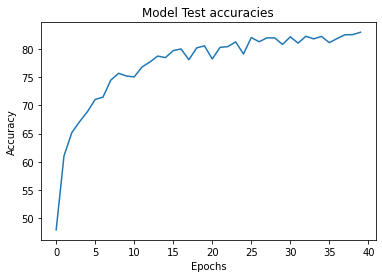

In [16]:
fig, ax = plt.subplots()
ax.plot(accuracies)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Model Test accuracies')
plt.savefig('Accuracies.png')
plt.show()

In [17]:
total_params = sum(param.numel() for name, param in  model.named_parameters())


In [18]:
readme = f'''

# Advanced Convolutions
This notebook implements CIFAR10 classification CNN using PyTorch 

----
| Attribute | Value |
|:--- | :--- |
| Test Accuracy | {np.max(accuracies)} |
| Trained Parameter count   |{total_params} |
| Dropout | {DROPOUT} |
| Total Epochs | {EPOCHS} |

----

![](Accuracies.png)

The model uses:
* 3x3 Convolution
* 1x1 / Pointwise Convolution
* Dilated / Atrous Convolution
* Depthwise Separable Convolution
* Max Pooling

To run 


You can install dependencies using  
`$ pip install -r req.txt`

'''

with open('README.md', 'w') as f:
    f.write(readme)